# Import libraries

In [1]:
# check the requirements.txt to see all installations needed

import pandas as pd 
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import glob
import matplotlib
import sklearn
import math
import timeit
import warnings
warnings.filterwarnings('ignore')

import kerastuner as kt
import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

from tensorflow.keras.layers import LeakyReLU
from tensorflow import keras
from tensorflow.keras import layers


# Form 

In [10]:
""" FORM - Used Compute a value between 0:1 for the performance of the 
    team on the games that were provided. Last game having the largest 
    weight. E.g. 4 games ['W', 'L', 'D', 'W'] 
    (left being the latest game), they will
    have weights [4,3,2,1] and scores [3, 0, 1, 3].
    """

def form(games):

    weight = len(games)
    score_sum = 0
     
    for game in games:
        if game is 'W':
            # If your win add 3, times the weight of the game
            score_sum = score_sum + weight*3
            # If your draw add 1 point, times the weight of the game
        elif game is 'D':
            score_sum = score_sum + weight*1
            
        else:
            score_sum = score_sum + 0
        
        # Diminish the weight for the next game 
        weight = weight - 1
    
#     form formula as seen in the research paper
    score_sum = score_sum*2/( 3*len(games)*(1+len(games)))
    return score_sum


def compute_team_streak(df, x):
    
    # Each one of these records the performance of each team based on location
    team_home_streaks = {}
    team_away_streaks = {}
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
        team_home_streaks[team] = 0  
        team_away_streaks[team] = 0
        
    home_streaks_home_team = []
    home_streaks_away_team = []
    
    away_streaks_home_team = []
    away_streaks_away_team = []
    
    for i in range(len(df)):
        current_row = df.iloc[i]
        
        home_streaks_home_team.append( team_home_streaks[current_row['HomeTeam']])
        home_streaks_away_team.append( team_home_streaks[current_row['AwayTeam']])
        
        away_streaks_home_team.append( team_away_streaks[current_row['HomeTeam']])
        away_streaks_away_team.append( team_away_streaks[current_row['AwayTeam']])
        
        # k is the number of previous games to consider and passed in as a parameter, 
        # .iloc[-k:] takes care of only including last k games. 
        home_last_x = df.iloc[:i+1].loc[(df['HomeTeam'] == current_row['HomeTeam'])].iloc[-x:]
        away_last_x = df.iloc[:i+1].loc[(df['AwayTeam'] == current_row['AwayTeam'])].iloc[-x:]
        
# convert the 'H' seen in the original data to 'W'. Repeat with Draw and Loss for home and away.        
        home_last_games = []
        for res in home_last_x['FTR']:
            if res == 'H':
                home_last_games.append('W')
            elif res == 'D':
                home_last_games.append('D')
            else:
                home_last_games.append('L')
        
        away_last_games = []
        for res in away_last_x['FTR']:
            if res == 'H':
                away_last_games.append('L')
            elif res == 'D':
                away_last_games.append('D')
            else:
                away_last_games.append('W')
                
        # compute weighted streak score for the last games

        home_updated = form(home_last_games)
        away_updated = form(away_last_games)

        # update the dictionary
        team_home_streaks[ current_row['HomeTeam']] = home_updated
        team_away_streaks[ current_row['AwayTeam']] = away_updated
   
    #   add form calculations to dataframe
    df['home_streak_home_team'] = home_streaks_home_team
    df['home_streak_away_team'] = home_streaks_away_team 
    
    df['away_streak_home_team'] = away_streaks_home_team
    df['away_streak_away_team'] = away_streaks_away_team
    
    return df



# Elo

In [11]:

""" SOFT RESET the elo score of each team for the next
    season. With factor = 2 would give the value between 
    current score and current mean for all teams"""

# original Soft reset formula
# def update_season_elo(current_elo, mean, factor):
#     new_elo = (current_elo - mean)/factor  + mean
#     return new_elo

# updated SOFT ELO reset
def update_season_elo(current_elo, mean, factor):    
    new_elo = (mean + (factor*current_elo))/(1 + factor)

    return new_elo


# MARGIN OF VICOTRY added to the Elo Rating.
# NOTE: This is not used in the final model.
def compute_G( mov, dr):
    if mov <= 1:
        value = 1
    else:
        value = 1.7*mov*(2/(2+0.001*dr))
        value = math.log( value, 2)
        
    return value


#  Team A vs Team B - calculate the expected probability of Team A winning vs Team B
def expected(A, B):
    return 1 / (1 + 10 ** ((B - A) / 400))

#  Team B vs Team A - calculate the expected probability of Team B winning vs Team B
def expectedB(B, A):
    return 1 / (1 + 10 ** ((A - B) / 400))

# Calculates the new Elo score of the Team. Margin of Victory not currently used. 
def elo(old, exp, score, k=32, mov=0, dr=300):
    return old + k * (score - exp) 

# Margin of Victory formula (line 43) not included as it produces worse accuracy.
#     return old + k * compute_G(mov, dr)*(score - exp) 



"""
    Computer elo scores for each team given a specific season. 
    
    df: is the dataframe containing the season
    global_score: is the cummulative elo scores from the previous seasons
    avegae: average elo score at the end of previous seaso
    initial_k: the initial value of the k parameter
    factor: fraction by which k is decreased after each game 
    
    Return:
        elo_scores for the end of this season 
        and updated dataframe. 
"""


def compute_elo_scores(df, global_score, average, initial_k, factor):
    # If you have never played you get the average score at the end of the previous season

    elo_scores = {}
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):  
        # If never played
        if global_score[team] == -1:
            elo_scores[team] = average
        else:
            elo_scores[team] = global_score[team]
    
    
    """k value for each team 
    that decreases by factor of 'factor' each time the team plays
    Starts with initial_k value.""" 
    
    k_scores = {}
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
        k_scores[team] = initial_k
        
        
    # Placeholders for the resulting columns 
    elo_at_the_end_of_game_home = []
    elo_at_the_end_of_game_away = []

    for i in range(len(df)):
        current_row = df.iloc[i] # Take the current row
        
        # Add the previous scores
        elo_at_the_end_of_game_home.append( elo_scores[ current_row['HomeTeam']])
        elo_at_the_end_of_game_away.append( elo_scores[ current_row['AwayTeam']])

        # depedning on who wins update the score. 
        if current_row['FTR'] == 'H':
            home_score = 1
            away_score = 0
        elif current_row['FTR'] == 'D':
            home_score = 0.5
            away_score = 0.5
        else:
            home_score = 0
            away_score = 1
         
        
        # Do the elo computation 
        home_expected = expected( elo_scores[ current_row['HomeTeam']], elo_scores[ current_row['AwayTeam']])
        home_actual_score = elo( elo_scores[ current_row['HomeTeam']], home_expected , home_score, 
                                k=k_scores[current_row['HomeTeam']] ) #,  mov=mov, dr=300)
        
        #k_scores[current_row['HomeTeam']]
        away_expected = expected( elo_scores[ current_row['AwayTeam']], elo_scores[ current_row['HomeTeam']])
        away_actual_score = elo( elo_scores[ current_row['AwayTeam']], away_expected , away_score, 
                                k=k_scores[current_row['AwayTeam']]) #, mov=mov, dr=300)
        
        #Update the scores
        elo_scores[current_row['HomeTeam']] = home_actual_score
        elo_scores[current_row['AwayTeam']] = away_actual_score
        
        # Decrease the value of k by a factor for each team. 
        k_scores[current_row['HomeTeam']] = k_scores[current_row['HomeTeam']] - factor*k_scores[current_row['HomeTeam']]
        k_scores[current_row['AwayTeam']] = k_scores[current_row['AwayTeam']] - factor*k_scores[current_row['HomeTeam']]
        
    
    # Add back to the dataframe. 
    df['Home_points_elo'] = elo_at_the_end_of_game_home
    df['Away_points_elo'] = elo_at_the_end_of_game_away 
    
    return df, elo_scores

# Match Statistics

In [12]:
# computes a number of different performance metrics
def compute_team_points(df):
    
    # Create a dictionary with all the teams that are playing
    # And initialize teams scores to 0.
    team_points = {}
    team_shots = {}
    team_goal_difference = {}
    team_shots_faced = {}
    team_red = {}
    
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
        team_points[team] = 0
        team_shots [team] = 0
        team_goal_difference [team] = 0
        team_shots_faced [team] = 0
        team_red[team] = 0
    
    # The number of games played per team starts with 0.
    team_gp_played = {}
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
        team_gp_played[team] = 0   
    
    # This is the points of the team per game. 
    team_points_per_game = {}
    for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
        team_points_per_game[team] = 0
    
    # Account for the fact that we have 1 column per Team.
    points_at_the_end_of_game_home = []
    points_at_the_end_of_game_away = []
    
    # One column per Team.
    average_points_home = []
    average_points_away = []
    
    shots_total_home = []
    shots_total_away = []
    
    team_goal_difference_end_home = []
    team_goal_difference_end_away = []
    
    team_red_home = []
    team_red_away = []
    
    team_shots_faced_home = []
    team_shots_faced_away = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        
        # First add points from the previous game. 
        points_at_the_end_of_game_home.append( team_points[current_row['HomeTeam']])
        points_at_the_end_of_game_away.append( team_points[current_row['AwayTeam']])
            
        average_points_home.append( team_points_per_game[current_row['HomeTeam']] )
        average_points_away.append( team_points_per_game[current_row['AwayTeam']] )
        
        # If the home team wins
        if current_row['FTR'] == 'H':
            # Update team points (3 points go to home, and 0 go to Away)
            team_points[current_row['HomeTeam']] = team_points[current_row['HomeTeam']] + 3
            team_points[current_row['AwayTeam']] = team_points[current_row['AwayTeam']] + 0
        
        # If it is a draw each team gets a single point
        if current_row['FTR'] == 'D':          
            team_points[current_row['HomeTeam']] = team_points[current_row['HomeTeam']] + 1
            team_points[current_row['AwayTeam']] = team_points[current_row['AwayTeam']] + 1
        
        # And if the away team wins it gets the 3 points. 
        if current_row['FTR'] == 'A':
            team_points[current_row['HomeTeam']] = team_points[current_row['HomeTeam']] + 0
            team_points[current_row['AwayTeam']] = team_points[current_row['AwayTeam']] + 3
            
            
        # Update number of times played
        team_gp_played[current_row['HomeTeam']] = team_gp_played[current_row['HomeTeam']] + 1
        team_gp_played[current_row['AwayTeam']] = team_gp_played[current_row['AwayTeam']] + 1
            
        # Update average points  
        team_points_per_game[current_row['HomeTeam']] = team_points[current_row['HomeTeam']] / team_gp_played[current_row['HomeTeam']]
        team_points_per_game[current_row['AwayTeam']] = team_points[current_row['AwayTeam']] / team_gp_played[current_row['AwayTeam']]            
    
        # update the shots average       
        shots_total_home.append( team_shots[current_row['HomeTeam']])
        shots_total_away.append( team_shots[current_row['AwayTeam']])
        team_shots[current_row['HomeTeam']] = (team_shots[current_row['HomeTeam']] + current_row['HS'])/ team_gp_played[current_row['HomeTeam']]
        team_shots[current_row['AwayTeam']] = (team_shots[current_row['AwayTeam']] + current_row['AS'])/ team_gp_played[current_row['AwayTeam']] 
        
        # team shots faced average
        team_shots_faced_home.append( team_shots[current_row['HomeTeam']])
        team_shots_faced_away.append( team_shots[current_row['AwayTeam']])
        team_shots_faced[current_row['HomeTeam']] = (team_shots[current_row['HomeTeam']] + current_row['AS'])/ team_gp_played[current_row['HomeTeam']]
        team_shots_faced[current_row['AwayTeam']] = (team_shots[current_row['AwayTeam']] + current_row['HS'])/ team_gp_played[current_row['AwayTeam']]
                
        
        # goal difference        
        team_goal_difference_end_home.append( team_goal_difference[current_row['HomeTeam']])
        team_goal_difference_end_away.append( team_goal_difference[current_row['AwayTeam']])
        team_goal_difference[current_row['HomeTeam']] = (team_goal_difference[current_row['HomeTeam']] + current_row['FTHG'] - current_row['FTAG'])
        team_goal_difference[current_row['AwayTeam']] = (team_goal_difference[current_row['AwayTeam']] - current_row['FTHG'] + current_row['FTAG'])
    
    
    
    # Add match statistics to the dataset
    
    
    df['H_Shots_Faced'] = team_shots_faced_home
    df['A_Shots_Faced'] = team_shots_faced_away
    
    df['H_Goal_Dif'] = team_goal_difference_end_home
    df['A_Goal_Dif'] = team_goal_difference_end_away
        
    df['H_Shots_Total'] = shots_total_home
    df['A_Shots_Total'] = shots_total_away
     
    df['Home_points'] = points_at_the_end_of_game_home
    df['Away_points'] = points_at_the_end_of_game_away 

    df['Average_home_points'] = average_points_home
    df['Average_away_points'] = average_points_away 
    
    return df


# Prepare and read the data

In [13]:
# Standardize values to zero mean and deviation of 1
def standardize(X):
    X = (X - np.mean(X))/np.std(X)
    return X


# Normalize - put values in between 0 and 1 
def normalize(X):
    X = (X - np.min(X))/(np.max(X)-np.min(X))
    return X


In [14]:
# Set inital Elo K value
INITIAL_K = 30

# Set how much the K value decreases (as a %) after evry game
K_FACTOR = 0.04

# The number of games included in the form calculation
X_STREAK = 5

In [15]:
# getting betting odds for late use
sef = ['WHH','WHD','WHA']

usef_before = ['HomeTeam', 'AwayTeam'] # Info available before the match.
usef_after = ['FTHG','FTAG','FTR','HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR','HS','AS']

usef = usef_before + usef_after

label = 'FTR'

# Take all the files in the dataset
database_path = 'archive/20*'

# sort them by date
filenames = sorted(glob.glob(database_path))

# All the teams that ever play in the PL
all_teams_across_seasons = ['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool',
                               'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff',
                               'Charlton', 'Chelsea', 'Crystal Palace', 'Derby', 'Everton',
                               'Fulham', 'Huddersfield', 'Hull', 'Ipswich', 'Leeds', 'Leicester',
                               'Liverpool', 'Man City', 'Man United', 'Middlesbrough',
                               'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading',
                               'Sheffield United', 'Southampton', 'Stoke', 'Sunderland',
                               'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham',
                               'Wigan', 'Wolves']

# Initialize the global elo_score for all teams.
global_elo_score = {}
for team in all_teams_across_seasons:
    global_elo_score[team] = -1

In [16]:
frames = [] 

for i, filename in enumerate(filenames):
    print(filename)
    """Prepare full path to the folder. Use the following if on Windows
     name = filename.split("\\")[0] + '/' + filename.split("\\")[1] """
    
    name = filename.split("/")[0] + '/' + filename.split("/")[1] 
    
    # Read csv and extract useful columns
    df = pd.read_csv( name, error_bad_lines=False)
    
    # Take all the useful columns
    df = df[usef]
    
    # Compute team poins for this season 
    df = compute_team_points(df)
    
    # Compute team streak for this season 
    df = compute_team_streak(df, X_STREAK)
    
    # Compute average elo score
    # from the end of last season. 
    
    # If this is first season
    if i == 0:
        # Start with 1000
        global_average = 1000
    else:
        # Compute the average
        global_average = 0
        num_of_teams = 0
        
        for key in global_elo_score.keys():
            if global_elo_score[key] != -1:
                global_average += global_elo_score[key]
                num_of_teams += 1
        
        # Sum of all points divided by the number of teams
        global_average = global_average/num_of_teams
    
    # Compute elo scores for this season
    df, elo_season = compute_elo_scores(df, global_elo_score.copy(), global_average, INITIAL_K, K_FACTOR)
    
    # Add the name of the season to the dataset 
    # filename.split('.')[0][-9:] gives  '20xx-20xx'
    # where xx are the years
    df['Season'] = filename.split('.')[0][-9:]
    
    # Add the season with updated columns to the final datframe
    frames.append( df)
    
    # Update the GLOBAL elo score ahead of the next season 
    
    # First calculate the average for this season
    score_average = 0
    for key in elo_season.keys():
        score_average += elo_season[key]
    score_average = score_average/20
    
    # print that average
    print('ELO MEAN: {}'.format(score_average))
    
#     SOFT RESET the elo scores for the next season
    for key in elo_season.keys():
        global_elo_score[key] = update_season_elo(elo_season[key], score_average, 2 )
        

archive/2000-2001.csv
ELO MEAN: 1000.5218593841959
archive/2001-2002.csv
ELO MEAN: 1008.0093637219346
archive/2002-2003.csv
ELO MEAN: 1008.1326309309403
archive/2003-2004.csv


b'Skipping line 305: expected 57 fields, saw 72\nSkipping line 306: expected 57 fields, saw 72\nSkipping line 307: expected 57 fields, saw 72\nSkipping line 308: expected 57 fields, saw 72\nSkipping line 309: expected 57 fields, saw 72\nSkipping line 310: expected 57 fields, saw 72\nSkipping line 311: expected 57 fields, saw 72\nSkipping line 312: expected 57 fields, saw 72\nSkipping line 313: expected 57 fields, saw 72\nSkipping line 314: expected 57 fields, saw 72\nSkipping line 315: expected 57 fields, saw 72\nSkipping line 316: expected 57 fields, saw 72\nSkipping line 317: expected 57 fields, saw 72\nSkipping line 318: expected 57 fields, saw 72\nSkipping line 319: expected 57 fields, saw 72\nSkipping line 320: expected 57 fields, saw 72\nSkipping line 321: expected 57 fields, saw 72\nSkipping line 322: expected 57 fields, saw 72\nSkipping line 323: expected 57 fields, saw 72\nSkipping line 324: expected 57 fields, saw 72\nSkipping line 325: expected 57 fields, saw 72\nSkipping li

ELO MEAN: 1015.1915605456122
archive/2005-2006.csv
ELO MEAN: 1010.9436353150384
archive/2006-2007.csv
ELO MEAN: 1021.5532320893965
archive/2007-2008.csv
ELO MEAN: 1016.459111059285
archive/2008-2009.csv
ELO MEAN: 1022.0866631752069
archive/2009-2010.csv
ELO MEAN: 1024.1208968906296
archive/2010-2011.csv
ELO MEAN: 1026.469570758539
archive/2011-2012.csv
ELO MEAN: 1028.6800849246285
archive/2012-2013.csv
ELO MEAN: 1031.6765499395863
archive/2013-2014.csv
ELO MEAN: 1035.4637620505657
archive/2015-2016.csv
ELO MEAN: 1035.4571250406239
archive/2016-2017.csv
ELO MEAN: 1035.926338038449
archive/2017-2018.csv
ELO MEAN: 1041.1205339924786
archive/2018-2019.csv
ELO MEAN: 1038.1216729082162
archive/2019-2020.csv
ELO MEAN: 1040.1609112432882


In [ ]:
# df['Season']
# X.to_csv (r'C:\Users\SeanMcNamara\Documents\modelX.csv', index = False)

In [17]:
# Put all seasons into a single dataframe
X = pd.concat(frames).dropna()

# Take the outcome cell
y = X['FTR']
# Drop it from the X
X = X.drop(columns='FTR')

# Create ONE-HOT-ENCODING of the Full time result. 
y_cont = np.zeros((len(y), 3))

for i, label in enumerate(y):
    if label == 'H':
        y_cont[i] = np.array([1,0,0])
    elif label == 'D':
        y_cont[i] = np.array([0,1,0])
    else:
        y_cont[i] = np.array([0,0,1])

# do not HomeTeam or AwayTeam as a feature
X = X.drop(columns='HomeTeam')
X = X.drop(columns='AwayTeam')

seasons = X['Season']
X = X.drop( columns = 'Season')

In [18]:
# Take the test data to use for Google Cloud

# z = X[X['Season'].isin(['2018-2019', '2019-2020'])]
# z.to_csv (r'C:\Users\SeanMcNamara\Documents\modelTestNN.csv', index = False)

In [19]:
# Take the columns that are going to be used in the model
# X_b = X[['Home_points_elo', 'Away_points_elo' , 'home_streak_home_team', 'home_streak_away_team', 'away_streak_home_team', 
#          'away_streak_away_team',
#         'Average_home_points','Average_away_points', 'H_Shots_Total',
#          'A_Shots_Total', 'H_Shots_Faced', 'A_Shots_Faced']]
X_b = X[['Average_home_points', 'Average_away_points', 'H_Shots_Total', 'A_Shots_Total','H_Shots_Faced','A_Shots_Faced',
        'H_Goal_Dif', 'A_Goal_Dif']]

X_b= X_b.apply(normalize)


In [20]:
# Separate last two seasons for testing

separation_point = 0
separation_point_2 = 0

# take the 2018/2019 and 2019/20 seaason for testing
for i in range(len(seasons)):
    if seasons.iloc[i] == '2018-2019' and separation_point == 0:
        separation_point = i
    if seasons.iloc[i] == '2019-2020' and separation_point_2 == 0:
        separation_point_2 = i        
        
X_train = np.copy( X_b[:separation_point])
X_test = np.copy( X_b[separation_point:])

y_train = np.copy( y_cont[:separation_point])
y_test = np.copy( y_cont[separation_point:])

# Create Neural Networks

## Keras Tuner


In [52]:
# define the model and add limitations to the search e.g. maximum number of neurons
# taken from https://keras-team.github.io/keras-tuner/

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(8, )))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=8, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(3))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('0.001', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model


In [68]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3
                    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_data=( X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of neurons in the first layer is {best_hps.get('units')} 
and the optimal learning rate 
is {best_hps.get('learning_rate')}.
""")

# find the optimal number of epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=25, validation_data=( X_test, y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Trial 60 Complete [00h 00m 03s]
val_accuracy: 0.2407894730567932

Best val_accuracy So Far: 0.5526315569877625
Total elapsed time: 00h 02m 40s
INFO:tensorflow:Oracle triggered exit


ValueError: learning_rate does not exist.

# Model 1 - 3 outputs

<!-- Model 1 - 3 outputs -->

In [69]:
# Define the model here

layer1 = layers.Dense(256, activation = 'relu', name="layer1", input_shape = (8,))

'''
List of different activation functions:
ReLu, SeLu, elu, softmax, softplus
'''
# Dropout used after first layer
tf.keras.layers.Dropout(.1, input_shape=(2,))

layer2 = layers.Dense(256, activation = 'relu', name="layer2")
batchnorm2 = layers.BatchNormalization()

# layer4 = layers.Dense(216, activation = 'relu', name="layer3" )
# layer5 = layers.Dense(216, activation = 'relu', name="layer4" )
# layer6 = layers.Dense(216, activation = 'relu', name="layer5" )

layer3 = layers.Dense(3, activation = 'softmax', name='output')


model_layers = [layer1,  layer2,  layer3]
model = keras.Sequential(model_layers)

# model.add(LeakyReLU(alpha=0.1))

model.summary()
loss = tf.keras.losses.CategoricalCrossentropy( from_logits = False )

"""
List of different loss functions
loss = tf.keras.losses.Poisson() 
loss = tf.keras.losses.KLDivergence()
loss = tf.keras.losses.MeanSquaredError()
loss = tf.keras.losses.MeanSquaredLogarithmicError() 
loss = tf.keras.losses.Huber()
loss = tf.keras.losses.Hinge()
"""

opt = keras.optimizers.Adam(lr = 0.001)

"""
List of different loss functions:
SGD
RMSprop
Adam
Adadelta
Adagrad
Adamax
Nadam
Ftrl
"""

model.compile( optimizer=opt, loss = loss, metrics=['accuracy'])
history = model.fit( x=X_train, y=y_train, validation_data=( X_test, y_test), batch_size= 512, epochs=20)


#model.load_weights( 'path to the folder')
#model.save_weights('saved_model/model_with_56_accuracy')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 256)               2304      
_________________________________________________________________
layer2 (Dense)               (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 3)                 771       
Total params: 68,867
Trainable params: 68,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12/12 [==============================] - 2s 54ms/step - loss: 1.0681 - accuracy: 0.4744 - val_loss: 1.0155 - val_accuracy: 0.4737
Epoch 2/20
12/12 [==============================] - 0s 12ms/step - loss: 1.0294 - accuracy: 0.4851 - val_loss: 0.9838 - val_accuracy: 0.5250
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 1.0066 - accuracy: 0.5031

# Model 2 - 1 output layout

In [70]:
y_train_2 = np.argmax(y_train, 1)/2
y_test_2 = np.argmax(y_test, 1)/2

In [71]:
# Define the tensorflow model here
layer1 = layers.Dense(128, activation = 'relu', name="layer1", input_shape = (8,))
batchnorm1 = layers.BatchNormalization()
layer2 = layers.Dense(256, activation = 'relu', name="layer2")
#batchnorm2 = layers.BatchNormalization()
# layer4 = layers.Dense(1024, activation = 'relu', name="layer3" )
#batchnorm3 = layers.BatchNormalization()
layer3 = layers.Dense(1, name='output')


model_layers = [layer1,  layer2,  layer3]
model = keras.Sequential( model_layers)

model.add(LeakyReLU(alpha=0.1))

#model.load_weights( 'path to the folder')
model.summary()
#loss = tf.keras.losses.CategoricalCrossentropy( from_logits = False )
loss = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile( optimizer=opt, loss = loss)
model.fit( x=X_train, y=y_train_2, validation_data=( X_test, y_test_2), batch_size= 32, epochs=15)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 128)               1152      
_________________________________________________________________
layer2 (Dense)               (None, 256)               33024     
_________________________________________________________________
output (Dense)               (None, 1)                 257       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1)                 0         
Total params: 34,433
Trainable params: 34,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
189/189 [==============================] - 3s 11ms/step - loss: 0.1907 - val_loss: 0.1637
Epoch 2/15
189/189 [==============================] - 0s 2ms/step - loss: 0.1587 - val_loss: 0.1605
Epoch 3/15
189/189 [===========================

In [72]:
predictions = model.predict(X_test)

In [73]:
# threshold can be chaged so that the number of draws predicted can be controlled
# high threshold means, high number of draws

predicted_outcome = [] 

threshold = 0.0001
for prediction in predictions:
    if prediction < 0.5 - threshold:
        predicted_outcome.append(0)
    elif prediction > 0.5 + threshold:
        predicted_outcome.append(2)
    else:
        predicted_outcome.append(1)

# get the accuracy of the second model
100* accuracy_score( np.argmax(y_test, 1), predicted_outcome)

55.65789473684211

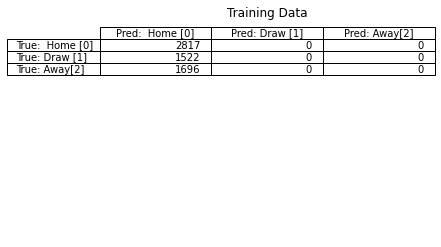

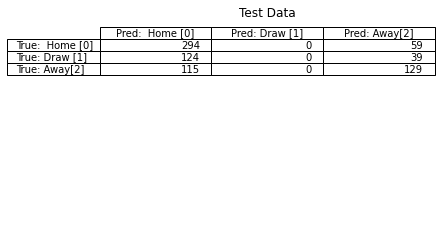

In [74]:
# confusion matrix of training model
rowlabel=("True:  Home [0]", "True: Draw [1]", "True: Away[2]")
collabel=("Pred:  Home [0]", "Pred: Draw [1]", "Pred: Away[2]")


y_predicted_train = model.predict(X_train)
train_cm = confusion_matrix( np.argmax(y_train,1), np.argmax(y_predicted_train,1), labels = [0, 1, 2])
plt.axis('tight')
plt.axis('off')
plt.title('Training Data')
plt.table( cellText= train_cm , colLabels=collabel, rowLabels=rowlabel, loc = 'upper center' , fontsize = 20)
plt.show()

# confusion matrix of model 2's predictions
rowlabel=("True:  Home [0]", "True: Draw [1]", "True: Away[2]")
collabel=("Pred:  Home [0]", "Pred: Draw [1]", "Pred: Away[2]")

y_predicted_train = model.predict(X_train)
train_cm = confusion_matrix( np.argmax(y_test,1), predicted_outcome, labels = [0, 1, 2])
plt.axis('tight')
plt.axis('off')
plt.title('Test Data')
plt.table( cellText= train_cm , colLabels=collabel, rowLabels=rowlabel, loc = 'upper center' , fontsize = 20)
plt.show()

# Google Cloud Predictions

In [75]:
# read prediction file made by Google AI platform
googlePredictions = pd.read_csv( 'archive/googleCloudPredictions2.csv', error_bad_lines=False)

In [76]:
# Extract predictions by Google 
googleP = googlePredictions[['FTR_H_score', 'FTR_A_score' , 'FTR_D_score']]
google = np.argmax( np.array(googleP), 1)

In [77]:
g_numerical = []

# one hot encode the full time result
for i, label in enumerate(googlePredictions['FTR']):
    if label == 'H':
        g_numerical.append(0)
    elif label == 'A':
        g_numerical.append(1)
    else:
        g_numerical.append(2)

In [78]:
test_accuracy = accuracy_score( g_numerical, google)
print('Google AI platform test accuracy: {}'.format(test_accuracy * 100))

Google AI platform test accuracy: 54.736842105263165


# Betting 

In [79]:
# Read Predictions by William Hill.

betting_frames = []
usef = ['WHH','WHD','WHA', 'FTR']
labe = 'FTR'

for i, filename in enumerate(filenames):
    #  if on windows use the following:   
    # name = filename.split("\\")[0] + '/' + filename.split("\\")[1] 
    name = filename.split("/")[0] + '/' + filename.split("/")[1] 
    
    # Read csv and extract useful columns
    df = pd.read_csv( name, error_bad_lines=False)
    df = df[usef]
    
    df['Season'] = filename.split('.')[0][-9:]
    betting_frames.append( df)
        

b'Skipping line 305: expected 57 fields, saw 72\nSkipping line 306: expected 57 fields, saw 72\nSkipping line 307: expected 57 fields, saw 72\nSkipping line 308: expected 57 fields, saw 72\nSkipping line 309: expected 57 fields, saw 72\nSkipping line 310: expected 57 fields, saw 72\nSkipping line 311: expected 57 fields, saw 72\nSkipping line 312: expected 57 fields, saw 72\nSkipping line 313: expected 57 fields, saw 72\nSkipping line 314: expected 57 fields, saw 72\nSkipping line 315: expected 57 fields, saw 72\nSkipping line 316: expected 57 fields, saw 72\nSkipping line 317: expected 57 fields, saw 72\nSkipping line 318: expected 57 fields, saw 72\nSkipping line 319: expected 57 fields, saw 72\nSkipping line 320: expected 57 fields, saw 72\nSkipping line 321: expected 57 fields, saw 72\nSkipping line 322: expected 57 fields, saw 72\nSkipping line 323: expected 57 fields, saw 72\nSkipping line 324: expected 57 fields, saw 72\nSkipping line 325: expected 57 fields, saw 72\nSkipping li

For William Hill test accuracy: 0.5605263157894737


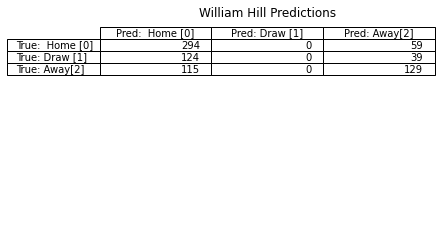

In [82]:
# confusion matrix of predicted test data for 2017/18 and 2018/19 william hill

test_accuracy = accuracy_score( np.argmax(y_test,1), wh_prediction)
print('For William Hill test accuracy: {}'.format(test_accuracy))

rowlabel=("True:  Home [0]", "True: Draw [1]", "True: Away[2]")
collabel=("Pred:  Home [0]", "Pred: Draw [1]", "Pred: Away[2]")

plt.figure()
y_predicted_train = model.predict(X_train)
# train_cm = confusion_matrix( np.argmax(y_test,1), predicted_outcome, labels = [0, 1, 2])
test_cm = confusion_matrix( np.argmax(y_test,1), predicted_outcome, labels = [0, 1, 2])
plt.axis('tight')
plt.axis('off')
plt.title('William Hill Predictions')
plt.table(cellText= test_cm , colLabels=collabel, rowLabels=rowlabel, loc = 'upper center' , fontsize = 20)
#plt.show()

For William Hill test accuracy: 0.5605263157894737


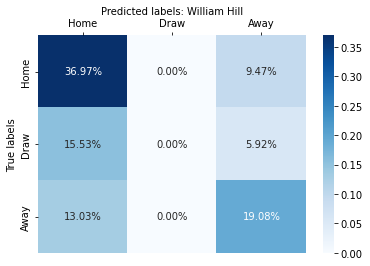

In [83]:
# confusion matrix of predicted test data for 2017/18 and 2018/19 william hill

y_predicted_test = model.predict(X_test)
test_cm = confusion_matrix( np.argmax(y_test,1), wh_prediction, labels = [0, 1, 2])

# as a percentage
ax= plt.subplot()
sns.heatmap(test_cm/np.sum(test_cm),annot=True, cmap='Blues', ax = ax, fmt='.2%')

# labels, title and ticks
ax.set_xlabel('Predicted labels: William Hill');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Home', 'Draw','Away']); ax.yaxis.set_ticklabels(['Home', 'Draw','Away']);

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

test_accuracy = accuracy_score( np.argmax(y_test,1), wh_prediction)
print('For William Hill test accuracy: {}'.format(test_accuracy))
# save as png file
# plt.savefig('testing.png')

In [84]:
# Drop nan values
XB = pd.concat(betting_frames).dropna()

# List of seasons that will be considered when computing earnings
games_to_consider = ['2018-2019', '2019-2020']
XB = pd.concat( [XB[XB['Season'] == x] for x in games_to_consider]) 

In [85]:
# Converting label to numerical 
y = XB['FTR']
XB = XB.drop(columns='FTR')

y_numerical = []

for i, label in enumerate(y):
    if label == 'H':
        y_numerical.append(0)
    elif label == 'D':
        y_numerical.append(1)
    else:
        y_numerical.append(2)


In [86]:
# Extract predictions by William and model predictions. 
wh_pred = XB[['WHH', 'WHD', 'WHA']]
wh_prediction = np.argmin( np.array(wh_pred), 1)
our_prediction = np.argmax( np.array(y_predicted_test ), 1)

In [87]:
# kKelly Criterion - used to estimate how much of bankroll should be spent on a bet
def kelly_rating(odds, estimate):
    return ( (((odds-1)*(estimate)) - (1-estimate) )/(odds-1) )*100

In [88]:
# Kelly Criterion

balance = 1000
balance_over_time = []

for i in range(len(wh_prediction)):
    
    # Difference between your and William Hill probability
    difference = y_predicted_test[i, our_prediction[i]] - (1/np.array(wh_pred))[i, our_prediction[i]]
    
    # If the difference is between a cetain margin. 
    if difference > 0.00 and difference < 0.3:
        
        # Extract from Kelly the percentage of your balance you want to bet
        kelly_percentage = kelly_rating( wh_pred.iloc[i, our_prediction[i]] , y_predicted_test[i, our_prediction[i]] )
        amount_to_invest = kelly_percentage * balance / 100
        
        # Make bet and change your balance based on the outcome. 
        if wh_prediction[i] == y_numerical[i]:
            balance = balance + amount_to_invest*(wh_pred.iloc[i, wh_prediction[i]] - 1)
        else:
            balance = balance - amount_to_invest
        
        # Add to balance over time. 
        balance_over_time.append(balance)
        
print(balance)

0.031117691660847043


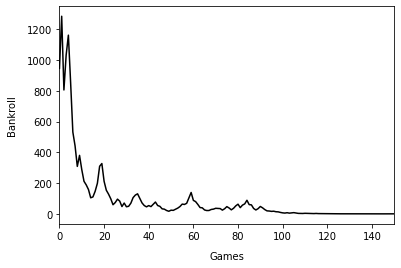

In [89]:
# keely Criterion balance 
plt.ylabel('Bankroll', labelpad = 10) 
plt.xlabel('Games', labelpad = 10) 

plt.xlim(0, 150)
plt.plot(balance_over_time, color = 'black')

# plt.savefig('kellyCriterion.png', bbox_inches='tight')

In [90]:
# Betting on the prediction of the model

winning = 0
winnings = []
x = 0
# y_numerical is the actual rsult

for i in range(len(wh_prediction)):

#     model predicting a home win
    if predicted_outcome[i] == 0:
        if y_numerical[i] == 0:
            winning = winning + wh_pred.iloc[i, 0] - 1

        else:
            winning = winning - 1

#     model predicting a draw win
    if predicted_outcome[i] == 1:
        if y_numerical[i] == 1:
            winning = winning + wh_pred.iloc[i, 1] - 1

        else:
            winning = winning - 1

#     model predicting an away win
    if predicted_outcome[i] == 2:
        if y_numerical[i] == 2:
            winning = winning + wh_pred.iloc[i, 2] - 1

        else:
            winning = winning - 1
    
    
    
    winnings.append(winning)
    
print(winning)

-0.019999999999974483


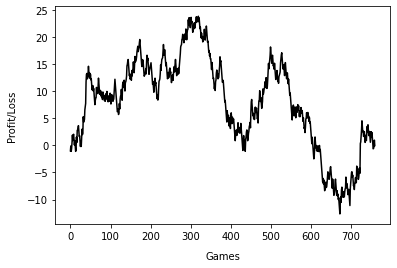

In [91]:
plt.ylabel('Profit/Loss', labelpad = 10) 
plt.xlabel('Games', labelpad = 10) 

plt.plot(winnings, color = 'black')

# plt.savefig('predictionBetting.png', bbox_inches='tight')


In [106]:
# Betting on the draw

winning = 0
winnings = []
x = 0
# y_numerical is the actual rsult

for i in range(len(wh_prediction)):

    if predicted_outcome[i] == 1:
        if y_numerical[i] == 1:
            winning = winning + wh_pred.iloc[i, 1] - 1

        else:
            winning = winning - 1
    
    winnings.append(winning)
    
print(winning)

0


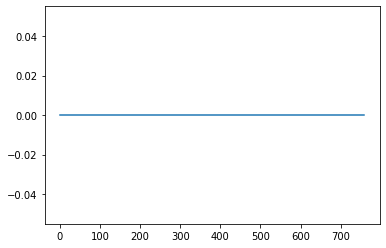

In [107]:
plt.plot(winnings)

-30.18000000000001


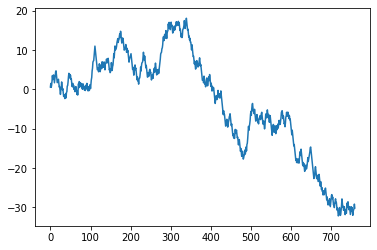

In [94]:
#  If you bet on the favourite using William Hills odds you would have lost £30 over 2 seasons.

winning = 0
winnings = []
for i in range(len(wh_prediction)):
    
    if wh_prediction[i] == y_numerical[i]:
        winning = winning + wh_pred.iloc[i, wh_prediction[i]] - 1
    else:
        winning = winning - 1
        
    winnings.append(winning)
        
print(winning)

plt.plot(winnings)

In [104]:
winning = 0
winnings = []
x = 0

for i in range(len(wh_prediction)):
    
# Difference between model probablty and William Hill probability
    difference = y_predicted_test[i, our_prediction[i]] - (1/np.array(wh_pred))[i, our_prediction[i]]
    
    if difference > 0.00 : 

        if our_prediction[i] == y_numerical[i]:
            winning = winning + wh_pred.iloc[i, our_prediction[i]] - 1
        
        else:
            winning = winning - 1
            
        winnings.append(winning)
        
print(winning)

36.820000000000014


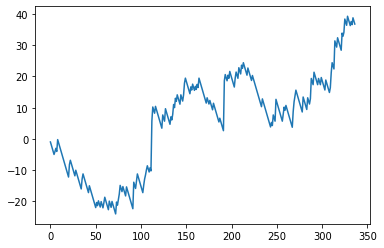

In [105]:
plt.plot(winnings)

In [97]:
# make a bet if William Hill is the same as our prediction

winning = 0
winnings = []

for i in range(len(wh_prediction)):
    
    if wh_prediction[i] == our_prediction[i]:
        if wh_prediction[i] == y_numerical[i]:
            winning = winning + wh_pred.iloc[i, wh_prediction[i]] - 1
        else:
            winning = winning - 1

        winnings.append(winning)
        
print(winning)

-25.330000000000013


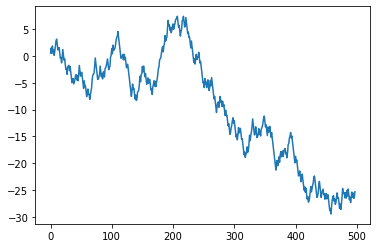

In [98]:
plt.plot(winnings)

# Code previously used 

## Margin of Victory (removed from model after testing)


In [99]:
def compute_G(mov,dr):
    value = 1.7*mov*(2/(2+0.001*dr))
    value = math.log( value, 2)

    return value

In [100]:
MOV = np.linspace(0,10,11)
G = []
dr = 300

def compute_G(mov,dr):
    value = 1.7*mov*(2/(2+0.001*dr))
    value = math.log( value, 2)

    return value

In [101]:
for mov in MOV:
    if mov <= 1:
        G.append(1)
    else:
        value = 1.7*mov*(2/(2+0.001*dr))
        value = math.log( value, 2)
        G.append(value)

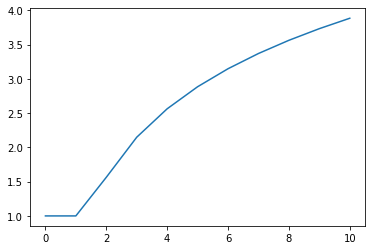

In [102]:
# plot graph and change the dr values

plt.plot(MOV, G)

#  Convert Catergorical data into numerical data

In [103]:
# NOTE: NOT NEEDED AFTER CHANGE TO FEATURES

# Separate numeric and categorical values
# numeric_data = X.select_dtypes(include=[np.number])
# #categorical_data = X.select_dtypes(exclude=[np.number])


# #categorical_data = categorical_data.apply(categorical_to_numerical)
# numeric_data = numeric_data.apply(standardize)

# X = pd.concat([ categorical_data, numeric_data], axis=1)

# # Write a function to convert categorical to numerical values
# def categorical_to_numerical_for_teams(columns):
#     uniqueNames = np.unique(columns)
    
#     columnNumericalHome = np.zeros(len(columns))
#     columnNumericalAway = np.zeros(len(columns))
    
#     for i, instance in enumerate(columns['HomeTeam']):
#         for j in range(len(uniqueNames)):
#             if uniqueNames[j] == instance:
#                 columnNumericalHome[i] = j
                
#     for i, instance in enumerate(columns['AwayTeam']):
#         for j in range(len(uniqueNames)):
#             if uniqueNames[j] == instance:
#                 columnNumericalAway[i] = j
                
#     return columnNumericalHome, columnNumericalAway

# # Write a function to convert categorical to numerical values
# def categorical_to_numerical(column):
#     uniqueNames = np.unique(column)
#     columnNumerical = np.zeros(len(column))
    
#     for i, instance in enumerate(column):
#         for j in range(len(uniqueNames)):
#             if uniqueNames[j] == instance:
#                 columnNumerical[i] = j
                
#     return columnNumerical


## Glicko Implementation - inconsistent results (potential bug)

In [ ]:
# def compute_glicko_for_RP(df, seasonal_scores):
    
#     for team in seasonal_scores.keys():
#         games = df.loc[ (df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        
#         opposing_scores = []
#         opposing_deviations = []
#         resuls = []
        
#         # go thorough all the games
#         for i in range(len(games_played)):
            
#             # if the current team is home team 
#             if games_played.iloc[i]['HomeTeam'] = team:
#                 opposing = games_played.iloc[i]['AwayTeam']
                
#                 if games_played.iloc[i]['FTR'] == 'H':
#                     results.append(1)
#                 elif games_played.iloc[i]['FTR'] == 'D':
#                     results.append(0.5)
#                 else:
#                     results.append(0)
                    
#             else:
#                 opposing = games_played.iloc[i]['HomeTeam']
                
#                 if games_played.iloc[i]['FTR'] == 'A':
#                     results.append(1)
#                 elif games_played.iloc[i]['FTR'] == 'D':
#                     results.append(0.5)
#                 else:
#                     results.append(0)
                
#             opposing_team = seasonal_scores[opposing]
            
            
#             opposing_scores.append( opposing_team.rating)
#             opposing_deviations.append( opposing_team.rd)

#         team_object = seasonal_scores[team]
#         team_object.update_player( opposing_scores, opposing_deviations, results)
#         seasonal_scores[team] = team_objects
        
#     return seasonal_scores

# def compute_glicko_for_season(df, fraction, global_glicko_objects):
    
#     # Initialize all the teams that are playing this season
#     seasonal_glicko_scores = {}
#     for team in np.unique(df[['HomeTeam', 'AwayTeam']]):
#         if global_glicko_objects[team] is None:
#             seasonal_glicko_scores[team] = Player()
#         else:
#             seasonal_glicko_scores[team] = global_glicko_objects[team]
            
#     # separate the season into fractions
#     F = int(round(len(df)*fraction))
    
#     i = 0
#     while (i*F < len(df)):
#         current_period = df.iloc[i*F:(i+1)*F]
#         updated_seasonal_scores = computer_glicko_for_RP( current_period, seasonal_glicko_scores)
#         seasonal_glicko_scores = updated_seasonal_scores
        
#         for team in global_glicko_objects:
#             if global_glicko_objects[team] is not None:
#                 if global_glicko_objects[team] not in np.unique(df[['HomeTeam', 'AwayTeam']]):
#                     global_glicko_objects[team] = global_glicko_objects[team].did_not_compete()
#         i = i + 1
    
    
    
#     return global_glicko_objects
        